# Finite elements for BVP with Neumann conditions

Example 6.10 - Inhomogeneous Neumann BVP

This example is taken from Gockenbach, Sect. 6.5.

In [1]:
%matplotlib inline

from sympy import *
init_printing()

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import solve_banded

# init_session()

In [2]:
u = symbols('u', cls=Function)
x = Symbol('x', real=True, domain=Interval(0,1))
l = Symbol('l', real=True, positive=True)
i = Symbol('i', integer=True)
h = Symbol('h', real=True, positive=True)

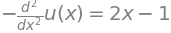

In [3]:
ode = Eq((-u(x).diff(x, x)), x*2-1, domain=Interval(0,1)); ode

In [4]:
rhs = ode.args[1]; rhs

In [5]:
ics = {
    u(0) : 0,
    u(1) : 0,
#     u(x).diff(x).subs(x, 0) : 0,
#     u(x).diff(x).subs(x, l) : 0,
}

In [6]:
u_true = dsolve(ode, func=u(x), ics=ics).args[1]; u_true

In [7]:
# Fix number of intervals
n = 10

## Implementing matrix representation of piecewise linear polynomials basis

Consider a uniformly spaced grid on the x axis, with n+1 nodes $x_i$, such that $x_0 = 0$ and $x_n = l$. Then consider the piecewise polynomials: every element $\phi_j$ takes some value in every interval, and this value can be viewed as the entry of a vector of n components. \
Ex. $\phi_0 = [-\frac{x}{h}+1, 0, 0, ..., 0]$ \
We can build a matrix whose rows are the vectors that represent the piecewise polynomials in the form that we have showed. With this convention, we have n+1 rows that represent the piecewise polynomials, and n columns, one for every interval.

Call each interval $X_j$ and each piecewise polynomial $\phi_i$. \
Build the analytical matrix with symbols as entries.

In [8]:
x_list = [Symbol(f'X_{i}') for i in range(n)]; x_list

In [9]:
phi_list = [symbols(f'phi_{i}', cls=Function) for i in range(n+1)]; phi_list

[phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6, phi_7, phi_8, phi_9, phi_10]

In [10]:
symbollist = []
for a in range(len(phi_list)):
    lista = [S.Zero for b in range(len(x_list))]
    for b in range(len(x_list)):
        if (a!=0)&(b==a-1):  lista[b]=phi_list[a](x_list[b])
        elif a==b:  lista[b]=phi_list[a](x_list[a])
    symbollist.append(lista)
symbolic = Matrix(symbollist); symbolic

⎡φ₀(X₀)    0       0       0       0       0       0       0       0        0 
⎢                                                                             
⎢φ₁(X₀)  φ₁(X₁)    0       0       0       0       0       0       0        0 
⎢                                                                             
⎢  0     φ₂(X₁)  φ₂(X₂)    0       0       0       0       0       0        0 
⎢                                                                             
⎢  0       0     φ₃(X₂)  φ₃(X₃)    0       0       0       0       0        0 
⎢                                                                             
⎢  0       0       0     φ₄(X₃)  φ₄(X₄)    0       0       0       0        0 
⎢                                                                             
⎢  0       0       0       0     φ₅(X₄)  φ₅(X₅)    0       0       0        0 
⎢                                                                             
⎢  0       0       0       0       0     φ₆(X₅)  φ₆(

In [11]:
symbollist_de = []
for a in range(len(phi_list)):
    lista = [S.Zero for b in range(len(x_list))]
    for b in range(len(x_list)):
        if (a!=0)&(b==a-1):  lista[b]=phi_list[a](x_list[b])
        elif a==b:  lista[b]=phi_list[a](x_list[a])
    symbollist_de.append(lista)
symbolic_de = Matrix(symbollist_de); symbolic_de

⎡φ₀(X₀)    0       0       0       0       0       0       0       0        0 
⎢                                                                             
⎢φ₁(X₀)  φ₁(X₁)    0       0       0       0       0       0       0        0 
⎢                                                                             
⎢  0     φ₂(X₁)  φ₂(X₂)    0       0       0       0       0       0        0 
⎢                                                                             
⎢  0       0     φ₃(X₂)  φ₃(X₃)    0       0       0       0       0        0 
⎢                                                                             
⎢  0       0       0     φ₄(X₃)  φ₄(X₄)    0       0       0       0        0 
⎢                                                                             
⎢  0       0       0       0     φ₅(X₄)  φ₅(X₅)    0       0       0        0 
⎢                                                                             
⎢  0       0       0       0       0     φ₆(X₅)  φ₆(

In [12]:
symbolic_de = symbolic.applyfunc(lambda entry : entry.diff(x, evaluate=False) if entry!=0 else 0); symbolic_de

⎡d                                                                            
⎢──(φ₀(X₀))      0           0           0           0           0           0
⎢dx                                                                           
⎢                                                                             
⎢d           d                                                                
⎢──(φ₁(X₀))  ──(φ₁(X₁))      0           0           0           0           0
⎢dx          dx                                                               
⎢                                                                             
⎢            d           d                                                    
⎢    0       ──(φ₂(X₁))  ──(φ₂(X₂))      0           0           0           0
⎢            dx          dx                                                   
⎢                                                                             
⎢                        d           d              

In [13]:
symbolic_Iij = symbolic_de*symbolic_de.T; symbolic_Iij

⎡                2                                                            
⎢    ⎛d         ⎞           d          d                                      
⎢    ⎜──(φ₀(X₀))⎟           ──(φ₀(X₀))⋅──(φ₁(X₀))                    0        
⎢    ⎝dx        ⎠           dx         dx                                     
⎢                                                                             
⎢                                   2               2                         
⎢d          d           ⎛d         ⎞    ⎛d         ⎞       d          d       
⎢──(φ₀(X₀))⋅──(φ₁(X₀))  ⎜──(φ₁(X₀))⎟  + ⎜──(φ₁(X₁))⎟       ──(φ₁(X₁))⋅──(φ₂(X₁
⎢dx         dx          ⎝dx        ⎠    ⎝dx        ⎠       dx         dx      
⎢                                                                             
⎢                                                                  2          
⎢                           d          d               ⎛d         ⎞    ⎛d     
⎢          0                ──(φ₁(X₁))⋅──(φ₂(X₁))   

In [14]:
symbolic_Kij = symbolic_Iij.applyfunc(
    lambda entry :
    Integral(UnevaluatedExpr(entry), (x, S.Zero, h)) if entry!=0
    else 0
); symbolic_Kij

⎡    h                                                                        
⎢    ⌠                           h                                            
⎢    ⎮             2             ⌠                                            
⎢    ⎮ ⎛d         ⎞              ⎮ d          d                               
⎢    ⎮ ⎜──(φ₀(X₀))⎟  dx          ⎮ ──(φ₀(X₀))⋅──(φ₁(X₀)) dx                   
⎢    ⎮ ⎝dx        ⎠              ⎮ dx         dx                              
⎢    ⌡                           ⌡                                            
⎢    0                           0                                            
⎢                                                                             
⎢                            h                                                
⎢h                           ⌠                                       h        
⎢⌠                           ⎮             2               2         ⌠        
⎢⎮ d          d              ⎮ ⎛d         ⎞    ⎛d   

## Numerical computation

In [15]:
# The first (and only) element of the e0 component
# From now on, the elements of the basis are called eX, with X their index,
# eXY are the entries of the matrix built with the vectors eX,
# deXY are the elements of the matrix of the derivatives,
# eXeY are the elements of the matrix that has the scalar products as components

# e00 = sy_basis.args[1][0]; e00 # this assignment leads to incompatibility
                                    # with other expressions and simplification
e00 = -x/h + i + S.One; print("e00 =", e00)

e00 = i + 1 - x/h


In [16]:
# enn = sy_basis.args[0][0]; enn
enn = x/h - i + S.One; print("enn =", enn)

enn = -i + 1 + x/h


In [17]:
sy_basis = Piecewise(
    (enn, (x>(i-1)*h)&(x<i*h)),
    (e00, (x>i*h)&(x<(i+1)*h)),
    (0, True),
); sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [18]:
# We build the matrix of the elements starting from a list of lists:
# each sublist is filled with conditional statements with the
# sympy objects e00 and enn that represent the values of the pp basis'
# elements in a given interval (represented by index j). The index i
# loops on the pp basis (from 0 to n) and is substituted in the expr
# e00 and enn. What we obtain is a pure sympy.Matrix object.

elist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a!=0)&(b==a-1): lista[b]=enn.subs(i, a)
        elif a==b: lista[b]=e00.subs(i, a)
        else: lista[b]=0
    elist.append(lista)
e = Matrix(elist); e

⎡    x                                                                        
⎢1 - ─    0       0       0       0       0       0       0       0       0   
⎢    h                                                                        
⎢                                                                             
⎢  x        x                                                                 
⎢  ─    2 - ─     0       0       0       0       0       0       0       0   
⎢  h        h                                                                 
⎢                                                                             
⎢            x      x                                                         
⎢  0    -1 + ─  3 - ─     0       0       0       0       0       0       0   
⎢            h      h                                                         
⎢                                                                             
⎢                    x      x                       

In [19]:
# Build the matrix of the derivatives via a lambda function passed as argument
# to the native sympy method sympy.applyfunc()
# The function differentiates each entry with respect to x.

de = e.applyfunc(lambda entry : entry.diff(x)); de

⎡-1                                              ⎤
⎢───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h                                              ⎥
⎢                                                ⎥
⎢ 1   -1                                         ⎥
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢      1   -1                                    ⎥
⎢ 0    ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h                                    ⎥
⎢                                                ⎥
⎢           1   -1                               ⎥
⎢ 0    0    ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h                               ⎥
⎢                                                ⎥
⎢                1   -1                          ⎥
⎢ 0    0    0    ─   ───   0    0    0    0    0 ⎥
⎢                h    h                          ⎥
⎢                              

In [20]:
# Implement an interval-wise scalar product by computing the matrix
# product of the matrix of the derivatives and its transpose.
# The resulting matrix is the matrix of the integrands of the matrix Kij,
# and we should call it Iij.

Iij = de*de.T; Iij

⎡1    -1                                              ⎤
⎢──   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ 2     2                                             ⎥
⎢h     h                                              ⎥
⎢                                                     ⎥
⎢-1   2    -1                                         ⎥
⎢───  ──   ───   0    0    0    0    0    0    0    0 ⎥
⎢  2   2     2                                        ⎥
⎢ h   h     h                                         ⎥
⎢                                                     ⎥
⎢     -1   2    -1                                    ⎥
⎢ 0   ───  ──   ───   0    0    0    0    0    0    0 ⎥
⎢       2   2     2                                   ⎥
⎢      h   h     h                                    ⎥
⎢                                                     ⎥
⎢          -1   2    -1                               ⎥
⎢ 0    0   ───  ──   ───   0    0    0    0    0    0 ⎥
⎢            2   2     2                        

In [21]:
# Since the entries of the matrix of the integrands are interval-wise,
# the integrals on each interval, which will be the entries of the matrix
# Kij, can be computed by integrating from 0 to h each entry of Iij.
# This is true only because the entries of Iij don't depend on the index
# of the piecewise element they refer to.

Kij = Iij.applyfunc(lambda entry : entry.integrate((x, S.Zero, h))); Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

## Implementing vector representation of rhs function

In [22]:
# The rhs function may be defined as a sympy object

rhs

In [23]:
If = e.applyfunc(lambda entry : entry*rhs); If

⎡⎛    x⎞                                                                      
⎢⎜1 - ─⎟⋅(2⋅x - 1)          0                   0                   0         
⎢⎝    h⎠                                                                      
⎢                                                                             
⎢   x⋅(2⋅x - 1)     ⎛    x⎞                                                   
⎢   ───────────     ⎜2 - ─⎟⋅(2⋅x - 1)           0                   0         
⎢        h          ⎝    h⎠                                                   
⎢                                                                             
⎢                   ⎛     x⎞            ⎛    x⎞                               
⎢        0          ⎜-1 + ─⎟⋅(2⋅x - 1)  ⎜3 - ─⎟⋅(2⋅x - 1)           0         
⎢                   ⎝     h⎠            ⎝    h⎠                               
⎢                                                                             
⎢                                       ⎛     x⎞    

In [24]:
# 2. build the matrix with the result of the integration of each
# integrand function (per interval, per piecewise element)

fflist = []
for a in range(n+1):
    lista = [0 for b in range(n)]
    for b in range(n):
        if (a==0): lista[b]=expand(If.row(a)[b].integrate((x, S.Zero, h)))
        elif (a==n): lista[b]=expand(If.row(a)[b].integrate((x, S.One-h, S.One)))
        else: lista[b]=expand(If.row(a)[b].integrate((x, a*h, (a+1)*h)))
    fflist.append(lista)
fij = Matrix(fflist); fij

⎡   2                                                                         
⎢  h    h                                                                     
⎢  ── - ─          0            0            0            0            0      
⎢  3    2                                                                     
⎢                                                                             
⎢    2            2                                                           
⎢14⋅h    3⋅h   4⋅h    h                                                       
⎢───── - ───   ──── - ─         0            0            0            0      
⎢  3      2     3     2                                                       
⎢                                                                             
⎢                 2            2                                              
⎢             23⋅h    3⋅h   7⋅h    h                                          
⎢     0       ───── - ───   ──── - ─         0      

In [25]:
# 3. build the vector fi, whose entries are the sums of the integrals
# on each piecewise element. To do that, we project each row on a
# column vector of ones.

ones = Matrix([S.One for i in range(n)])

flist = []
for a in range(n+1):
    flist.append(fij.row(a)*ones)
fi = Matrix(flist); fi

⎡      2         ⎤
⎢     h    h     ⎥
⎢     ── - ─     ⎥
⎢     3    2     ⎥
⎢                ⎥
⎢      2         ⎥
⎢   6⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  10⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  14⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  18⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  22⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  26⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  30⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  34⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢      2         ⎥
⎢  38⋅h  - 2⋅h   ⎥
⎢                ⎥
⎢    2           ⎥
⎢29⋅h    21⋅h    ⎥
⎢───── - ──── + 1⎥
⎣  3      2      ⎦

## Building a solution

Being Kij singular, one way to make it full-rank, thus invertible, is to remove its last row and column. The same must be applied to the fi vector, whose last element is popped. In this way, the linear algebra problem **Ku=f** has a unique solution.

In [26]:
Kij

⎡ 1   -1                                              ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                              ⎥
⎢                                                     ⎥
⎢-1    2   -1                                         ⎥
⎢───   ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                         ⎥
⎢                                                     ⎥
⎢     -1    2   -1                                    ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢      h    h    h                                    ⎥
⎢                                                     ⎥
⎢          -1    2   -1                               ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢           h    h    h                               ⎥
⎢                                                     ⎥
⎢               -1    2   -1                          ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0

In [27]:
K = Kij[0:-1, 0:-1]; K

⎡ 1   -1                                         ⎤
⎢ ─   ───   0    0    0    0    0    0    0    0 ⎥
⎢ h    h                                         ⎥
⎢                                                ⎥
⎢-1    2   -1                                    ⎥
⎢───   ─   ───   0    0    0    0    0    0    0 ⎥
⎢ h    h    h                                    ⎥
⎢                                                ⎥
⎢     -1    2   -1                               ⎥
⎢ 0   ───   ─   ───   0    0    0    0    0    0 ⎥
⎢      h    h    h                               ⎥
⎢                                                ⎥
⎢          -1    2   -1                          ⎥
⎢ 0    0   ───   ─   ───   0    0    0    0    0 ⎥
⎢           h    h    h                          ⎥
⎢                                                ⎥
⎢               -1    2   -1                     ⎥
⎢ 0    0    0   ───   ─   ───   0    0    0    0 ⎥
⎢                h    h    h                     ⎥
⎢                              

In [28]:
shape(K)

In [29]:
f = Matrix(fi[:-1]); f

⎡   2       ⎤
⎢  h    h   ⎥
⎢  ── - ─   ⎥
⎢  3    2   ⎥
⎢           ⎥
⎢   2       ⎥
⎢6⋅h  - 2⋅h ⎥
⎢           ⎥
⎢    2      ⎥
⎢10⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎢14⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎢18⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎢22⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎢26⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎢30⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎢34⋅h  - 2⋅h⎥
⎢           ⎥
⎢    2      ⎥
⎣38⋅h  - 2⋅h⎦

In [30]:
shape(f)

In [31]:
u = K.LUsolve(f); u = u.applyfunc(lambda x : expand(x)); u

⎡      3         ⎤
⎢2260⋅h        2 ⎥
⎢─────── - 95⋅h  ⎥
⎢   3            ⎥
⎢                ⎥
⎢              2 ⎥
⎢     3   189⋅h  ⎥
⎢753⋅h  - ────── ⎥
⎢           2    ⎥
⎢                ⎥
⎢      3         ⎥
⎢2240⋅h        2 ⎥
⎢─────── - 92⋅h  ⎥
⎢   3            ⎥
⎢                ⎥
⎢      3        2⎥
⎢2191⋅h    175⋅h ⎥
⎢─────── - ──────⎥
⎢   3        2   ⎥
⎢                ⎥
⎢      3       2 ⎥
⎢ 700⋅h  - 81⋅h  ⎥
⎢                ⎥
⎢      3        2⎥
⎢1955⋅h    145⋅h ⎥
⎢─────── - ──────⎥
⎢   3        2   ⎥
⎢                ⎥
⎢      3         ⎥
⎢1744⋅h        2 ⎥
⎢─────── - 62⋅h  ⎥
⎢   3            ⎥
⎢                ⎥
⎢              2 ⎥
⎢      3   99⋅h  ⎥
⎢ 485⋅h  - ───── ⎥
⎢            2   ⎥
⎢                ⎥
⎢      3         ⎥
⎢1076⋅h        2 ⎥
⎢─────── - 35⋅h  ⎥
⎢   3            ⎥
⎢                ⎥
⎢      3       2 ⎥
⎢ 595⋅h    37⋅h  ⎥
⎢ ────── - ───── ⎥
⎣   3        2   ⎦

In [32]:
shape(u)

In [33]:
# Now fix the length of the bar, e.g. l = 1 m, and substitute the value of h

l = 1 # m
hvalue = l/n; hvalue

In [34]:
y = list(u.subs(h, hvalue).evalf(5)); y

In [35]:
xgrid = [0+hvalue*i for i in range(n)]; xgrid

In [36]:
y_true = [u_true.subs(x, xgrid[i]).evalf(5) for i in range(n)]; y_true

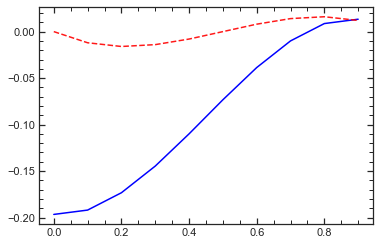

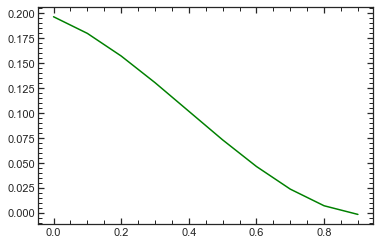

In [37]:
# Plot the approximated solution

plt.figure(1)
plt.plot(xgrid, y, color='blue')

# Plot the true solution
plt.plot(xgrid, y_true, linestyle='--', color='red', alpha=.9)

# Plot the differences
plt.figure(2)
error = [y_true[i]-y[i] for i in range(len(y))]
plt.plot(xgrid, error, color='green')

plt.show()

# Discussion

As one can appreciate by the differences' plot, the difference between the
approximated solution and the true (analytical) solution vanishes at the
nodes. The method implemented here does not permit to compute a more
refined approximated solution at this level. \
To do that, one should build a vector of y that contains an arbitrary
number of computed points exploiting the analytical form of u as a
function of h. \
The components of u, for a fixed h, restitutes the values of u at the
lower limits of the interval. in which they are defined. To find a function
that properly connects two consecutive points of u, one should interpolate
in some way, with a fitting routine.

In [38]:
g = []
for i in range(len(y)-1):
    g.append((y[i]+(y[i+1]-y[i])/hvalue*(x-hvalue*i)).evalf(2))
g

In [39]:
npoints = 100
npoints_per_interval = int(npoints/n)-1
x_subvalue = hvalue/npoints_per_interval

yrefined = []
xrefined = []
for index, entry in enumerate(g):
    for subinterval in range(npoints_per_interval):
        xval = hvalue*index+x_subvalue*subinterval
        yrefined.append(entry.subs(x, xval).evalf(5))
        xrefined.append(round(xval, 5))
yrefined = np.array(yrefined)
xrefined = np.array(xrefined)

In [40]:
y_truerefined = np.array([u_true.subs(x, xrefined[i]).evalf(5) for i in range(len(xrefined))]); # y_truerefined

In [41]:
error_refined = y_truerefined-yrefined; # error_refined

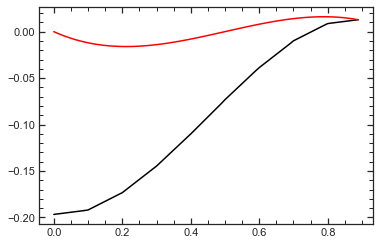

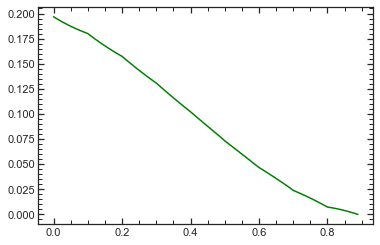

In [42]:
plt.close()

plt.figure(3)
plt.plot(xrefined, yrefined, color='black')
plt.plot(xrefined, y_truerefined, color='red')

plt.figure(4)
plt.plot(xrefined, error_refined, color='green')

plt.show()